In [1]:

import pandas as pd
from data_fetch import *
from datetime import date, timedelta
import numpy as np


TICKERS = ["SBER", "VTBR",  "SIBN",        "LKOH",    "ROSN"]
NAME    = ["Сбер", "ВТБ","Газпром Нефть", "Лукойл", "Роснефть"]

#Вычисляем вчерашнюю дату
yesterday = date.today() - timedelta(days=1)
YEST = yesterday.isoformat()

# цена закрытия для каждой акции с 1 января 2020 года до вчерашнего дня
close_series = {
    t: api_request(t, "2020-01-01", YEST)["close"]
    for t in TICKERS
}
prices = pd.concat(close_series, axis = 1)
prices.columns.name = "Ticker"
prices.index.name   = "Date"



## Выводим цену акций в момент закрытия торгов во вчерашний день

In [2]:

display(prices.loc[[YEST]])


Ticker,SBER,VTBR,SIBN,LKOH,ROSN
Date,,,,,
2025-05-28,308.47,95.78,529.25,6686.0,428.15


## Посмотрим как менялись акции СБЕРА и ВТБ  за последние 5 лет

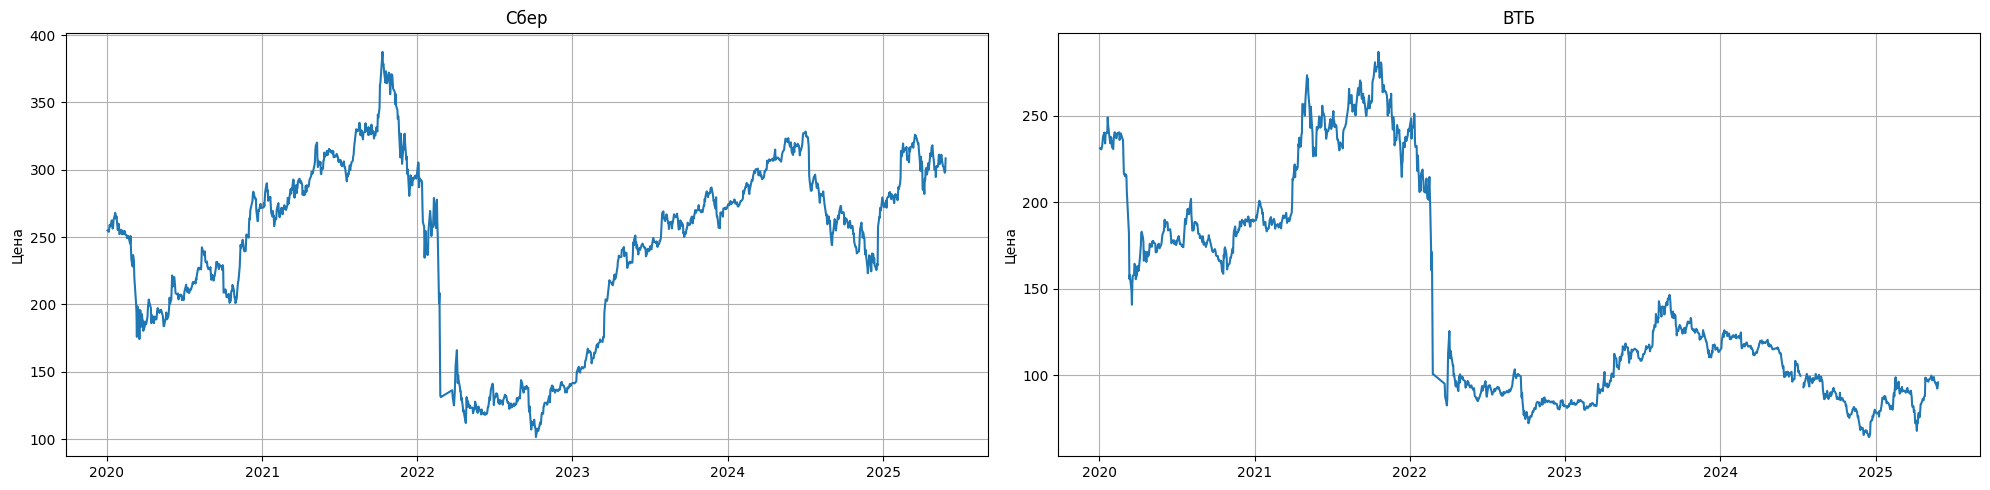

In [3]:
import math
import matplotlib.pyplot as plt


n = len(TICKERS[:2])
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharex=True)
axes = axes.flatten()

for ax, ticker, name in zip(axes, TICKERS[:2], NAME[:2]):
    ax.plot(prices.index, prices[ticker])
    ax.set_title(name)
    ax.set_ylabel("Цена")
    ax.grid(True)


plt.tight_layout()
plt.show()


## Посмотрим на Газпром Нефть, Лукойл и Роснефть

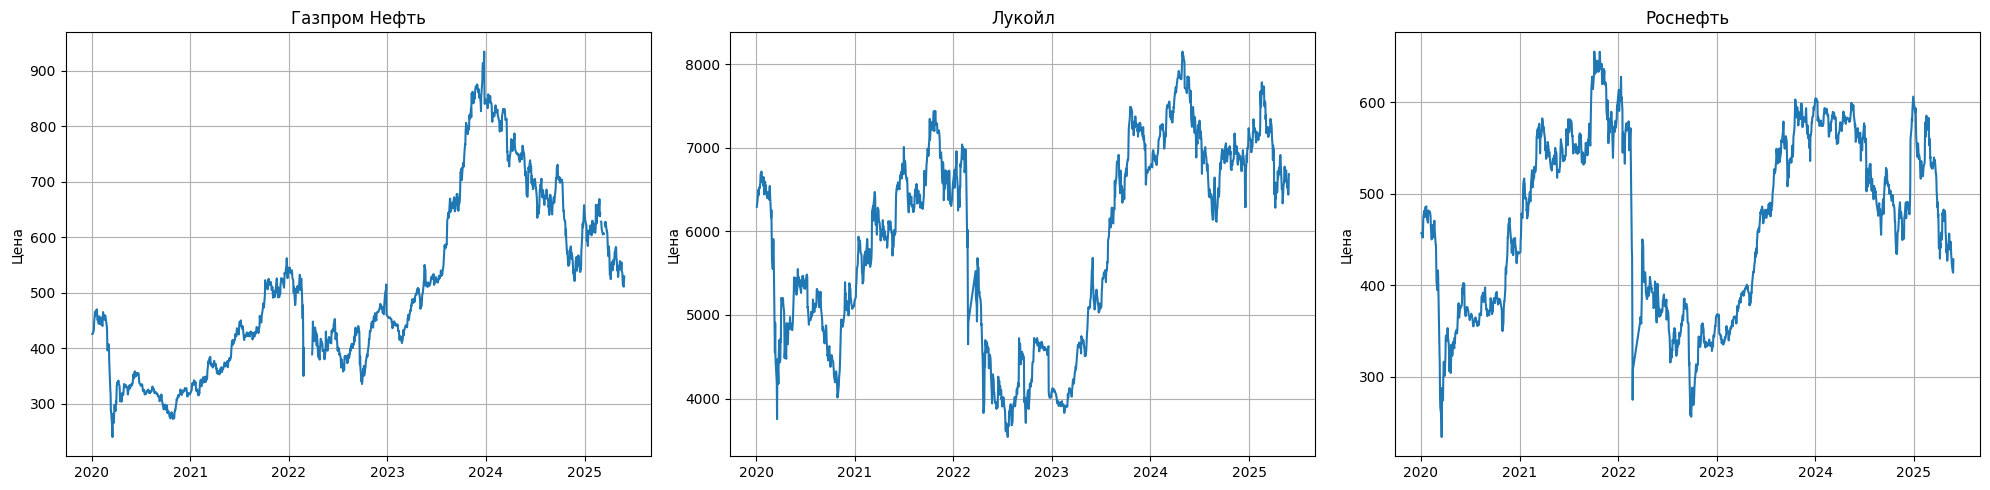

In [4]:
n = len(TICKERS[2:])
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharex=True)
axes = axes.flatten()

for ax, ticker, name in zip(axes, TICKERS[2:], NAME[2:]):
    ax.plot(prices.index, prices[ticker])
    ax.set_title(name)
    ax.set_ylabel("Цена")
    ax.grid(True)


plt.tight_layout()
plt.show()

## Посмотрим теперь на покатели этих акций, возьмём такие параметры:
### EPS — прибыль на акцию за последний отчётный год (Чистая прибыль / Кол-во акций)
### BVPS — балансовая стоимость на акцию             (Собственный капитал / Кол-во акций)
### DIV  — последняя фактическая дивидендная выплата

Для SBER: [EPS](https://smart-lab.ru/q/SBER/MSFO/eps/), [Собственный капитал](https://www.finmarket.ru/database/organization/?fid=7205), [диведенды](https://bcs.ru/markets/sber/tqbr/dividends?utm_referrer=https%3a%2f%2fwww.google.com%2f)  
Для VTBR (ВТБ): [EPS](https://smart-lab.ru/q/VTBR/MSFO/eps/), [Собственный капитал](https://www.finmarket.ru/database/organization/?fid=86040), [диведенды](https://bcs.ru/markets/vtbr/tqbr/dividends)  
Для SIBN (Газпром Нефть): [EPS](https://smart-lab.ru/q/SIBN/MSFO/eps/), [Собственный капитал](https://ru.wikipedia.org/wiki/%D0%93%D0%B0%D0%B7%D0%BF%D1%80%D0%BE%D0%BC_%D0%BD%D0%B5%D1%84%D1%82%D1%8C#cite_note-_973f292f34b1c548-4), [Диведенды](https://www.dohod.ru/ik/analytics/dividend/sibn)  
Для LKOH (Лукойл) : [EPS](https://smart-lab.ru/q/LKOH/MSFO/eps/), [Собственный капитал](https://ru.wikipedia.org/wiki/%D0%9B%D1%83%D0%BA%D0%BE%D0%B9%D0%BB), [Диведенды](https://www.dohod.ru/ik/analytics/dividend/lkoh)  
Для ROSN (Роснефть) : [EPS](https://smart-lab.ru/q/ROSN/MSFO/eps/), [Собственный капитал](https://ru.wikipedia.org/wiki/%D0%A0%D0%BE%D1%81%D0%BD%D0%B5%D1%84%D1%82%D1%8C), [Диведенды](https://bcs.ru/markets/rosn/tqbr/dividends) 


In [ ]:
import pandas as pd, numpy as np, requests

# ─── 1. функция, которая достаёт количество акций ────────────────────────────
def get_number(ticker: str) -> int:
    url = (f"https://iss.moex.com/iss/engines/stock/markets/shares/"
           f"securities/{ticker}.json?iss.only=securities")
    j = requests.get(url, timeout=10).json()
    cols, row = j["securities"]["columns"], j["securities"]["data"][0]
    info = dict(zip(cols, row))
    for k in ("issue_size", "issuesize", "ISSUESIZE"):
        if k in info and info[k]:
            return int(info[k])
    raise KeyError(f"{ticker}: поле issue_size не найдено")

# ─── 2. твой словарь с EPS + капиталом + дивидендами ────────────────────────
Params = {
    "SBER": {"EPS": 73.2,  "Equity": 7_184_029_299, "DIV": 34.84},
    "VTBR": {"EPS": 99.7,  "Equity": 2_116_313_275, "DIV": 25.58},
    "SIBN": {"EPS": 101.1, "Equity": 2_540_000_000, "DIV": 71.45},
    "LKOH": {"EPS": 1_252, "Equity": 4_520_000_000, "DIV": 1012},
    "ROSN": {"EPS": 102.3, "Equity": 6_490_000_000, "DIV": 36.47},
}

# ─── 3. считаем BVPS из Equity / Shares ──────────────────────────────────────
for t, p in Params.items():
    equity_rub = p["Equity"] * 1000
    shares     = get_number(t)         # штук акций
    p["BVPS"]  = equity_rub / shares   # баланс-стоимость на акцию

df_params = pd.DataFrame.from_dict(Params, orient="index")[["EPS", "BVPS", "DIV"]]
df_params.index.name = "Ticker"
display(df_params)


,EPS,BVPS,DIV
Ticker,,,
SBER,73.2,0.332795,34.84
VTBR,99.7,0.394104,25.58
SIBN,101.1,0.535718,71.45
LKOH,1252.0,6.523630,1012.00
ROSN,102.3,0.612369,36.47


In [13]:
# ─── 4. value-метрики (Грэм, P/E, P/B, DY) ───────────────────────────────────
last_prices = prices.iloc[-1]          # цена закрытия на вчера

rows = []
for t in Params:
    p   = last_prices[t]
    eps = Params[t]["EPS"]
    bv  = Params[t]["BVPS"]
    div = Params[t]["DIV"]

    graham = np.sqrt(22.5 * eps * bv)
    rows.append(dict(
        Ticker=t, Price=p, EPS=eps, BVPS=bv,
        GrahamPrice=graham,
        GrahamRatio=p / graham,
        P_E=p / eps,
        P_B=p / bv,
        DY_pct=div / p * 100
    ))

valuation = (pd.DataFrame(rows)
               .set_index("Ticker")
               .round(2)
               .sort_values("GrahamRatio"))
display(valuation)


,Price,EPS,BVPS,GrahamPrice,GrahamRatio,P_E,P_B,DY_pct
Ticker,,,,,,,,
VTBR,95.78,99.7,0.39,29.73,3.22,0.96,243.03,26.71
ROSN,428.15,102.3,0.61,37.54,11.40,4.19,699.17,8.52
SBER,308.47,73.2,0.33,23.41,13.18,4.21,926.91,11.29
SIBN,529.25,101.1,0.54,34.91,15.16,5.23,987.93,13.50
LKOH,6686.00,1252.0,6.52,428.68,15.60,5.34,1024.89,15.14
